# CS579: Assignment 2

In this assignment, we'll implement community detection and link prediction algorithms using Facebook "like" data.

The included file `edges.txt` indicates like relationships between facebook users. This was collected using the `snowball` function below, but you will not need to re-run this collection process. Instead, you will simply read `edges.txt` into an undirected networkx graph, as indicated below.

Complete the **eight** methods below that are indicated by `TODO`. I've provided some sample output to help guide your implementation.

In [3]:
from collections import defaultdict
from __future__ import division
import copy
#import facebook
import io
import matplotlib.pyplot as plt
import networkx as nx
import time
%matplotlib inline 

In [4]:
"""
You do not need to run this code. 

This is the code I used to collect "like" data from Facebook.
I include it here as an example that may or may not be helpful for 
your class project.
"""
def snowball(fb, tofind, found, edges, id2name, depth=0, maxdepth=2):
    """
    Given a seed set of users in `tofind`, recursively sample
    additional users that are "liked" by the original set.
    
    tofind....list of user ids to find
    found.....list of user ids we have already found
    edges.....dict from user id A to list of user ids B1,B2,..., where A likes B
    id2name...dict from user id to user name
    depth.....current depth of breadth-first sampling
    maxdepth..maximum depth to reach
    """
    tofind2 = copy.copy(list(tofind))  # make a copy since we modify `tofind` below.
    for userid in tofind2:
        print('getting likes for %s' % userid)
        friends = fb.get_connections(userid, "likes")
        time.sleep(1)  # to avoid rate limits.
        found.add(userid)
        tofind.remove(userid)
        for friend in friends['data']:
            id2name[friend['id']] = friend['name']
            edges[userid].add(friend['id'])
            if friend['id'] not in found:  # add if haven't seen already.
                tofind.add(friend['id'])
        print('%d tofind' % len(tofind))
    if depth < maxdepth:  # if should continue recursively.
        print('recursing with %d to find, %d found, and %d names' %
              (len(tofind), len(found), len(id2name)))
        snowball(fb, tofind, found, edges, id2name, depth+1, maxdepth)
    return edges

if False:  # don't actually run this.
    # see here: https://developers.facebook.com/tools/explorer/
    access_token = '<ENTER YOUR ACCESS TOKEN>'
    # Look at Bill Gates's profile for this example by using his Facebook id.
    user = 'BillGates'
    fb = facebook.GraphAPI(access_token)
    profile = fb.get_object(user)
    tofind = set([profile['id']])
    found = set()
    edges = defaultdict(lambda: set())
    id2name = {profile['id']: profile['name']}

    edges = snowball(fb, tofind, found, edges, id2name, 0, 2)
    
    # Write 'like' edges to a file.
    outf = io.open('edges.txt', 'w', encoding='utf8')
    for user, friends in edges.iteritems():
        for friend in friends:
            outf.write(id2name[user] + u'\t' + id2name[friend] + u'\n')
    outf.close()   

In [5]:
def read_graph():
    """ Read 'edges.txt' into a networkx **undirected** graph.
    Returns:
      A networkx undirected graph.
    """
    file = open('edges.txt', 'r')
    G=nx.Graph()
    for line in file:
        tuple = line.strip().split("\t")
        if (tuple not in G.edges()) and (tuple[::-1] not in G.edges()):
        #set.update(tuple)
            G.add_edge(*tuple)
    return G        
graph = read_graph()
#print(sorted(graph.nodes()))
print('graph has %d nodes and %d edges' % 
      (graph.order(), graph.number_of_edges()))

graph has 5062 nodes and 6060 edges


In [6]:
# Nodes with highest degree.
sorted(graph.degree().items(), key=lambda x: x[1], reverse=True)[:10]

[('ONE', 39),
 ('Bill & Melinda Gates Foundation', 39),
 ('NPR', 35),
 ('UN Women', 34),
 ('The New York Times', 34),
 ('Women Deliver', 34),
 ('I fucking love science', 33),
 ('Global Citizen', 33),
 ('Melinda Gates', 32),
 ('Show of Force: Social Good', 32)]

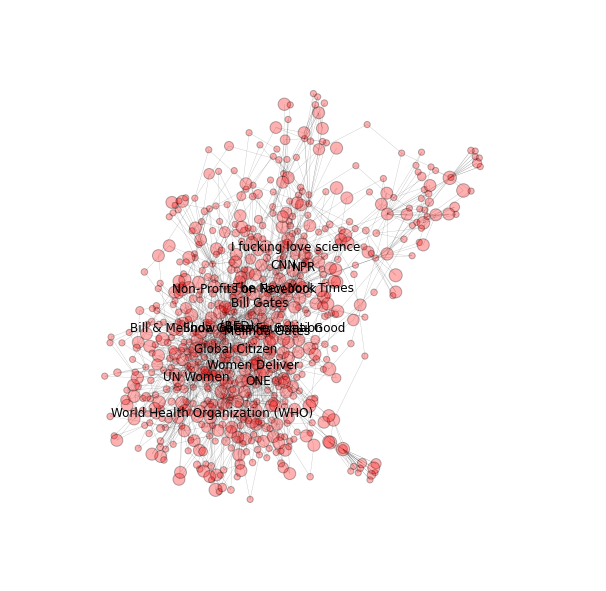

In [7]:
# I have provided this graph drawing method for you.
def draw_network(graph, draw_thresh=1, label_thresh=31,
                 min_node_sz=30, max_node_sz=200):
    """
    Draw a graph, filtering the nodes and labels based on degree.
    The size of nodes is proportional to degree.
    
    graph...........a networkx graph
    draw_thresh.....only draw nodes that have degree greater than this.
    label_thresh....only label nodes that have degree greater than this.
    min_node_size...smallest node size
    max_node_size...biggest node size
    """
    degrees = graph.degree()
    labels = {n: n for n, d in degrees.items() if d > label_thresh}
    plt.figure(figsize=(10,10))
    nodes_to_draw = [name for name, degree in degrees.items() if degree > draw_thresh]
    maxdegree = max(degrees.values())
    sz_range = max_node_sz - min_node_sz
    sizes = [min_node_sz + (1. * degrees[n] / maxdegree * sz_range)
             for n in nodes_to_draw]
    subgraph = graph.subgraph(nodes_to_draw)
    nx.draw_networkx(subgraph, alpha=.3, width=.3,
                     labels=labels, node_size=sizes)
    plt.axis("off")
    plt.show()
    
draw_network(graph)

## Community Detection

In [8]:
def get_subgraph(graph, min_degree):
    """Return a subgraph containing nodes whose degree is
    greater than min_degree.
    Args:
      graph........a networkx graph
      min_degree...degree threshold
    Returns:
      a networkx graph, filtered as defined above.
    """
    ###TODO
    ###
    degrees = graph.degree()
    nodes_to_draw = [name for name, degree in degrees.items() if degree > min_degree]
    subgraph = graph.subgraph(nodes_to_draw)
    return subgraph

subgraph = get_subgraph(graph, 1)
print('subgraph has %d nodes and %d edges' % 
      (subgraph.order(), subgraph.number_of_edges()))

subgraph has 712 nodes and 1710 edges


In [9]:
def girvan_newman(G, minsize=30, maxsize=100):
    """ Recursive implementation of the girvan_newman algorithm.
    This involves a couple modifications from our class code.
    
    - Rather than recompute betweenness after each edge is removed,
      only compute betweenness once per call to this method. That is,
      compute betweenness once, remove edges until multiple connected
      components are formed, then recurse.
      
    - Rather than return all communities, only return communities with
      size >= minsize and <= maxsize. To do this, halt recursion
      when this condition is met. E.g., if a split results in
      communities of size 50 and 200, the community of size 50
      will be added to the result set, while the community of size
      200 will be split again using a recursive call to this function.
      Similarly, if a split results in communities of size 50 and 1, 
      the size 50 community will be returned, while the size 1 community
      will not.
      
    **Note that the above procedure means that not all nodes will be
    assigned a community.
    
    Args:
    G.........a networkx graph
    minsize...the smallest acceptable size for a community
    maxsize...the largest acceptable size for a community

    Returns:
    A list of all discovered communities. This list is a list 
    of lists of strings. E.g., [['A', 'B'], ['C', 'D']] is a result
    containing two communities ((A,B) and (C,D)).
    """
    ###TODO
    ###
    if ((G.order() >= minsize) and (G.order() <= maxsize)):
        print "stopping for " + str(G.order())
        return [G.nodes()]
    
    betweenness_map = nx.edge_betweenness_centrality(G)
    edge_list = sorted(betweenness_map.items(), key=lambda x: x[1], reverse=True)
    # Each component is a separate community. We cluster each of these.
    components = [c for c in nx.connected_component_subgraphs(G)]
    count = 0
    while len(components) == 1:
        G.remove_edge(*edge_list[count][0])
        count+=1
        components = [c for c in nx.connected_component_subgraphs(G)]

    print('removed ' + str(count) + ' edges')
    print ('component size [%d, %d]' % (len(components[0]),len(components[1])))
    result=[]   
    for c in components:
        if c.order() > minsize:
            result.extend(girvan_newman(c, 30, 100))
    return result


result = girvan_newman(subgraph.copy(), minsize=30, maxsize=100)

removed 87 edges
component size [701, 11]
removed 3 edges
component size [695, 6]
removed 6 edges
component size [694, 1]
removed 2 edges
component size [693, 1]
removed 3 edges
component size [692, 1]
removed 6 edges
component size [691, 1]
removed 2 edges
component size [689, 2]
removed 2 edges
component size [688, 1]
removed 1 edges
component size [641, 47]
removed 188 edges
component size [634, 7]
removed 4 edges
component size [633, 1]
removed 12 edges
component size [632, 1]
removed 8 edges
component size [631, 1]
removed 6 edges
component size [630, 1]
removed 2 edges
component size [629, 1]
removed 2 edges
component size [628, 1]
removed 1 edges
component size [600, 28]
removed 6 edges
component size [599, 1]
removed 6 edges
component size [598, 1]
removed 2 edges
component size [597, 1]
removed 1 edges
component size [557, 40]
removed 25 edges
component size [554, 3]
removed 13 edges
component size [553, 1]
removed 1 edges
component size [546, 7]
removed 2 edges
component size

In [10]:
print('final cluster sizes:')
[len(x) for x in result]

final cluster sizes:


[100, 68, 100, 32, 40, 47]

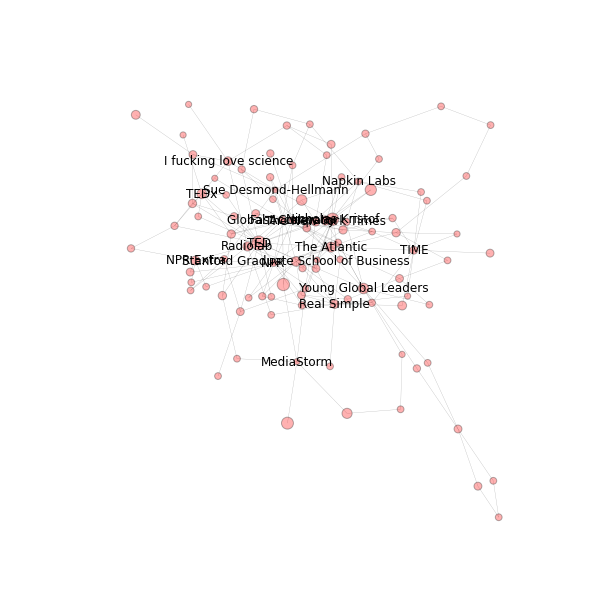

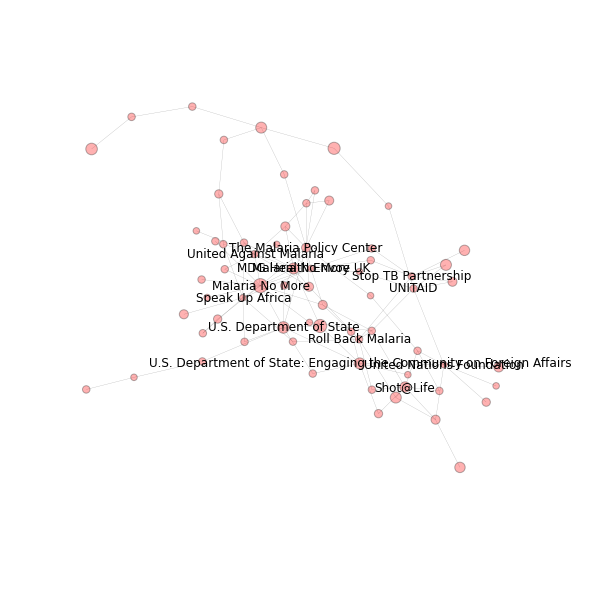

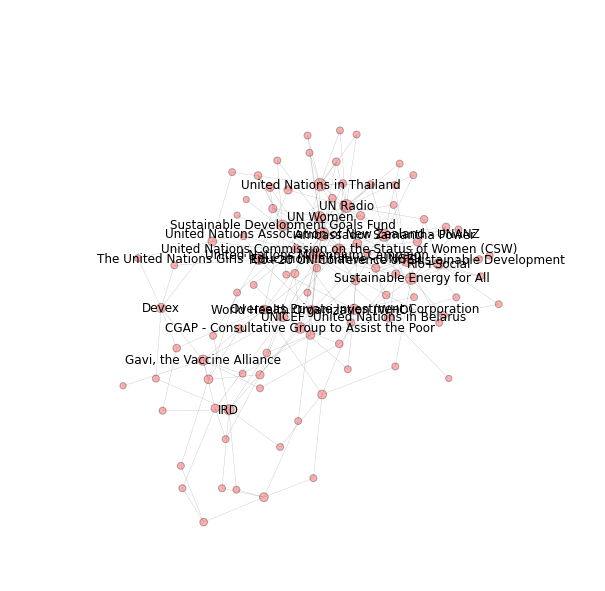

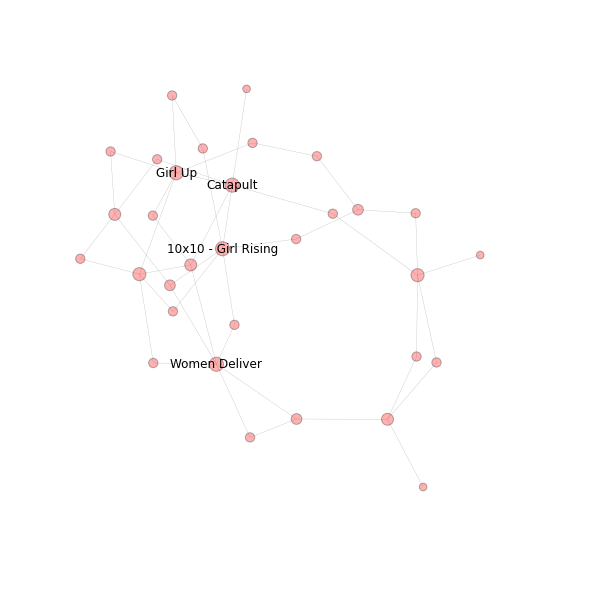

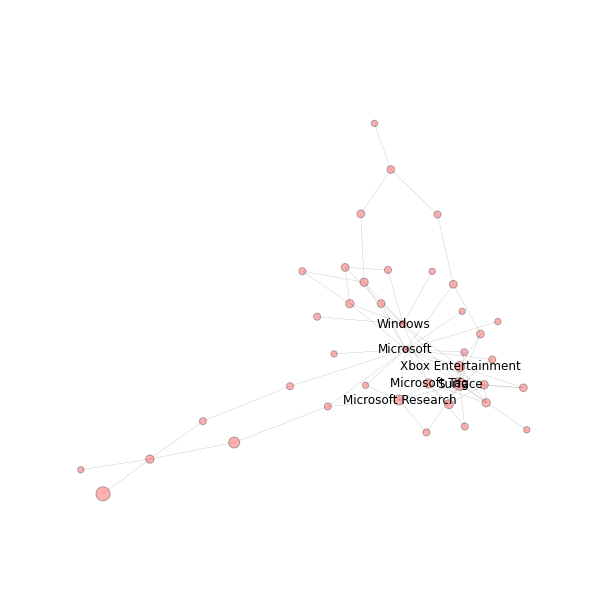

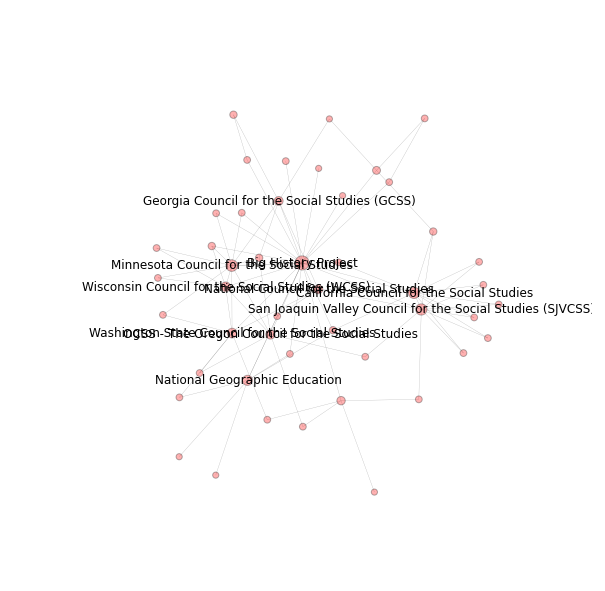

In [11]:
# Draw each cluster separately.
for cluster in result:
    draw_network(graph.subgraph(cluster), label_thresh=5, draw_thresh=0)

In [12]:
%matplotlib inline

# Compute the normalized cut for each discovered cluster.
def volume(nodes, graph):
    """
    Compute the volume for a set of `nodes`, which
    is the number of edges in `graph` with at least one end in
    nodes.
    Args:
      nodes...a list of strings for the nodes to compute the volume of.
      graph...a networkx graph
    """
    ###TODO
    ###
    count = 0
    for edge in graph.edges():
        if (edge[0] in nodes) or (edge[1] in nodes):
            count=count+1
    return count 
            

def cut(S, T, graph):
    """
    Compute the cut-set of the cut (S,T), which is
    the set of edges that have one endpoint in S and
    the other in T.
    Args:
      S.......set of nodes in first subset
      T.......set of nodes in second subset
      graph...networkx graph
    Returns:
      An int representing the cut-set.
    """
    ###TODO
    ###
    count = 0
    for edge in graph.edges():
        if (edge[0] in S) and (edge[1] in T):
            count=count+1
        elif(edge[0] in T) and (edge[1] in S):
            count=count+1
 
    return count 
    

def norm_cut_v(S, T, graph):
    """
    The normalized cut value for the cut S/T. (See lec06.)
    Args:
      S.......set of nodes in first subset
      T.......set of nodes in second subset
      graph...networkx graph
    Returns:
      An float representing the normalized cut value
    """
    ###TODO
    ###
    volume_S = volume(S,graph)
    volume_T = volume(T,graph)
    cut_size= cut(S,T,graph)
    if(volume_S!=0) and (volume_T!=0):
        return ((cut_size/volume_S)+(cut_size/volume_T))
    
def score_clusters(clusters, graph):
    """
    Compute the normalized cut value for each cluster returned 
    by the girvan newman algorithm above. To compute the value
    for one cluster, we consider the cut in which S is the
    proposed cluster, and T are all the other nodes in the graph.
    E.g., if the graph has nodes [A,B,C,D,E], and the proposed cluster
    is [A,B], then the cut value is computed on the cut
    S=[A,B], T=[C,D,E].
    
    Args:
      clusters....list of lists of strings representing the clusters
                  returned by the Girvan Newman algorithm.
      graph.......a networkx graph
    Returns:
      list of floats containing the normalized cut values for each cluster.
    """
    ###TODO
    ###
    norm_cut_list = []
    for cluster in result:
        non_cluster = [val for val in subgraph if val not in cluster]
        norm_cut_list.append(norm_cut_v(cluster,non_cluster, subgraph))
    return norm_cut_list
                            
score_clusters(result, subgraph)

[0.5394522186431889,
 0.7112986541855564,
 0.6125866583993509,
 0.7394497863247863,
 0.38487710745480397,
 0.169372331833391]

## Link prediction

Next, we'll consider the link prediction problem. In particular, 
we will remove 10 of the accounts that Bill Gates likes and 
compute our accuracy at recovering those links.

In [13]:
test_node = 'Bill Gates'
G_train = subgraph.copy()
edges_to_rem = subgraph.edges(test_node)[:10]
G_train.remove_edges_from(edges_to_rem)
print('original graph has %d nodes and %d edges' % 
      (subgraph.order(), subgraph.number_of_edges()))
print('train graph has %d nodes and %d edges' % 
      (G_train.order(), G_train.number_of_edges()))

original graph has 712 nodes and 1710 edges
train graph has 712 nodes and 1700 edges


In [14]:
print('removed the following edges:')
edges_to_rem

removed the following edges:


[('Bill Gates', 'Khan Academy'),
 ('Bill Gates', 'Pau Gasol'),
 ('Bill Gates', 'Big History Project'),
 ('Bill Gates', 'PATH'),
 ('Bill Gates', 'Vaccines Today'),
 ('Bill Gates', 'World Health Organization'),
 ('Bill Gates', 'TED'),
 ('Bill Gates', 'Bill & Melinda Gates Foundation'),
 ('Bill Gates', 'ONE'),
 ('Bill Gates', 'Sue Desmond-Hellmann')]

In [15]:
# I've done this one for you.
def evaluate(scores, graph, n=10):
    """ Returns the accuracy of the predicted link scores, filtering
        to the top `n` results.
    Args:
      scores....list of ((n1, n2), score) tuples, representing the 
                score assigned to edge (n1, n2)
      graph.....a networkx graph
      n.........Evaluate the top n values in scores.
    Returns:
      A float indicating the proportion of the top ranked edges
      in scores that are present in the graph.
    """
    predicted_edges = [x[0] for x in sorted(scores, key=lambda x: x[1], reverse=True)[:n]]
    return 1. * len([x for x in predicted_edges if graph.has_edge(*x)]) / len(predicted_edges)

In [16]:
# I've done this one for you.

def jaccard(graph, node):
    """ Jaccard similarity. Note that we don't
    return scores for edges that already appear in the graph.
    """
    scores = []
    neighborsi = set(graph.neighbors(node))
    for n in graph.nodes():
        if n != node and not graph.has_edge(node, n):
            neighborsj = set(graph.neighbors(n))
            score = 1. * (len(neighborsi & neighborsj)) / (len(neighborsi | neighborsj))
            scores.append(((node, n), score))
    return scores

jaccard_scores = jaccard(G_train, test_node)
print('jaccard accuracy=%.3f' % evaluate(jaccard_scores, subgraph, n=10))

jaccard accuracy=0.200


In [17]:
print('%d jaccard scores' % len(jaccard_scores))
print('top 5 recommendations:')
[x[0][1] for x in sorted(jaccard_scores, key=lambda x: x[1], reverse=True)[:5]]

690 jaccard scores
top 5 recommendations:


['Global Citizen',
 'Girl Effect',
 'Show of Force: Social Good',
 'Sue Desmond-Hellmann',
 'Global Poverty Project']

You will next implement a modified version of Jaccard as follows:
$$
jaccard_{wt}(A, B) = \frac{\sum_{i \in (A \cap B)} \frac{1}{deg(i)}}{\frac{1}{\sum_{i \in A} deg(i)} + \frac{1}{\sum_{j \in B} deg(j)}}
$$
where $A$ and $B$ are sets of neighbors of two nodes to be scored, and $deg(i)$ is the degree of node $i$.

This method attempts to account for the fact that if we share a neighbor
that has low degree, we should have a higher recommendation score than if we share a neighbor with high degree. (E.g., two people that like the relatively obscure band Gang of Four are probably more similar than two people that like Justin Bieber).

In [18]:
def jaccard_wt(graph, node):
    """
    The weighted jaccard score, defined above.
    Args:
      graph....a networkx graph
      node.....a node to score potential new edges for.
    Returns:
      A list of ((node, ni), score) tuples, representing the 
                score assigned to edge (node, ni)
                (note the edge order)
    """
    ###TODO
    ###
    scores = []
    neighborsi = set(graph.neighbors(node))
    for n in graph.nodes():
        if n != node and not graph.has_edge(node, n):
            neighborsj = set(graph.neighbors(n))
            inter_set = neighborsi & neighborsj
            
            degree_inter_set =  get_frac_degree(inter_set,graph) 
            degree_i= get_degree(neighborsi,graph)
            degree_j= get_degree(neighborsj,graph)
            score = float(degree_inter_set/(1/degree_i + 1/degree_j))
            scores.append(((node, n), score))
    return scores

def get_frac_degree(nodes,graph):
    degrees = graph.degree()
    fraction_degree_total=0
    for node in nodes:
          fraction_degree_total+=(1/degrees[node])
    return fraction_degree_total 

def get_degree(nodes,graph):
    degrees = graph.degree()
    degree_total=0
    for node in nodes:
          degree_total+=degrees[node]
    return degree_total 



jaccard_wt_scores = jaccard_wt(G_train, test_node)
print('jaccard_wt accuracy=%.3f' % evaluate(jaccard_wt_scores, subgraph, n=10))

jaccard_wt accuracy=0.400


In [19]:
print('%d jaccard_wt_scores' % len(jaccard_wt_scores))
print('top 5 recommendations:')
[x[0][1] for x in sorted(jaccard_wt_scores, key=lambda x: x[1], reverse=True)[:5]]

690 jaccard_wt_scores
top 5 recommendations:


['Bill & Melinda Gates Foundation',
 'Global Citizen',
 'ONE',
 'PATH',
 'Sue Desmond-Hellmann']

## Project

List three potential course project ideas here, 3-4 sentences each.
For each project, state briefly what you want to do, as well as **which data** you would need to collect:

1. Detecting people suffering from depression: We can use the data of the facebok profile to detect the users who are going through depression. We can use the following criterias for detecting the same.
        i) Sudden drop in the number of FB posts by any user (we can compare last six months data for any user and check the weekly posts posted by user. If they are declined in by a significan number, it may be a weak signal of isolation.)
       ii) Significant drop in the number of new freinds a person has made in recent time.
      iii) Doing sentiment analysis of the recent status messages posted by the user.
       iv) Reduction in the number of photo tags and places tags.
 This application can be used for:
     i) If a person is suspected to be goin through depression, we can send him the content and contacts which can help him, without leting him know anything about our analysis.
     ii) We can notify the close friends and family members about it.
 Note: Its just an idea and I need t check ho much data does Facebook provides through their API. 
 
  
2. Rumours and spam detection on twitter: We can make an application which try to detect the users spreading rumours and spams in the network. We will need the following data for it:
    i) Tweets which are being circulatedwih very high frequency on the network, which could be a potential spam or rumor.
   ii) The connectivity of the users which are spreading these tweets, with the rest of the world, to check whether its a fake account or not.
 
3. Sentiment analyser for organisations: An application which provides the relevant data to any organisation about what pople are talking about their product (service), and detecting the overall sentiment of the customers for that poduct or organisation.


In [20]:
# Do not modify this cell.
import json
outf = open('output.txt', 'wt')

exgraph = nx.Graph()
exgraph.add_edges_from([('A', 'B'), ('A', 'C'), ('B', 'C'),
                        ('B', 'D'), ('D', 'E'), ('D', 'F'),
                        ('D', 'G'), ('E', 'F'), ('G', 'F')])                                        
[sorted(x) for x in girvan_newman(exgraph.copy(), minsize=1, maxsize=2)]

json.dump({'graph_order': read_graph().order(),
           'graph_edges': len(read_graph().edges()),
           'subgraph_order': get_subgraph(read_graph(), 1).order(),
           'subgraph_edges': len(get_subgraph(read_graph(), 1).edges()),
           'subgraph_order_2': get_subgraph(read_graph(), 2).order(),
           'subgraph_edges_2': len(get_subgraph(read_graph(), 2).edges()),
           'gn_1_2': sorted([sorted(x) for x in girvan_newman(exgraph.copy(), minsize=1, maxsize=2)]),
           'gn_2_3': sorted([sorted(x) for x in girvan_newman(exgraph.copy(), minsize=2, maxsize=3)]),
           'gn_1_4': sorted([sorted(x) for x in girvan_newman(exgraph.copy(), minsize=1, maxsize=4)]),
           'volume1': volume(['A', 'B', 'C', 'D'], exgraph),
           'cut1': cut(['A', 'B', 'C', 'D'], ['E', 'F', 'G'], exgraph),
           'ncv1': norm_cut_v(['A', 'B', 'C', 'D'], ['E', 'F', 'G'], exgraph),
           'score_clusters': score_clusters(result, subgraph),
           'gn_sizes': [len(x) for x in result],
           'jaccard_wt': sorted(jaccard_wt(G_train, test_node),
                                key=lambda x: x[1], reverse=True)[:30]
          }, outf, indent=2, sort_keys=True)
outf.close()





removed 1 edges
component size [3, 4]
removed 2 edges
component size [2, 1]
removed 2 edges
component size [1, 3]
removed 1 edges
component size [3, 4]
removed 2 edges
component size [2, 1]
removed 2 edges
component size [1, 3]
removed 1 edges
component size [3, 4]
removed 2 edges
component size [2, 1]
removed 2 edges
component size [1, 3]
removed 1 edges
component size [3, 4]
removed 2 edges
component size [2, 1]
removed 2 edges
component size [1, 3]
